# Analysis of results from running experiments with three bodies present

Looking at results from 20 coordinate positions for ellipsoids and moth with wings

In [32]:
import sys
sys.path.append('/Users/sstk4353/packages/.')

from WIPL_python_analysis.SinglePolPlots import SinglePolPlots
from WIPL_python_analysis.DualPol import DualPol
from WIPL_python_analysis.DictToSinglePolResults import OutputDictToSinglePolResultsConverter as converter
import WIPL_python_analysis.helper_functions as hf
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./')

In [33]:
BASE_DRIVE_PATH = '/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/'
ELLIPSOIDS = 'multi_moth_outputs/three_ellipsoids/'
BERNARD_BODY = 'multi_moth_outputs/three_bernard_body/'

BERNARD_COMPARISON = 'Bernard/'
ELLIPSOID_COMPARISON = 'Ellipsoid/'

In [34]:
pol_list = ['H', 'V']
vars_list = ['HH_power', 'VV_power', 'Zdr', 'LDR', 'HH_phase', 'HH_phase_de_aliased', 'VV_phase', 'VV_phase_de_aliased','PhiDP', 'PhiDP_de_aliased', 'PhiDP_pre_de_aliased']

In [35]:
units_dict = {
    'HH_power': 'proportional',
    'VV_power': 'proportional',
    'Zdr': 'dB',
    'LDR': 'dB',
    'HH_phase': 'degrees',
    'VV_phase': 'degrees',
    'HH_phase_de_aliased': 'degrees',
    'VV_phase_de_aliased': 'degrees',
    'PhiDP': 'degrees',
    'PhiDP_de_aliased': 'degrees',
    'PhiDP_pre_de_aliased': 'degrees'
}

In [36]:
def de_alias(aliased_data):

    number_of_points = len(aliased_data)
    de_aliased_data = np.zeros(number_of_points)

    de_aliased_data[0] = aliased_data[0]

    for counter in range(1, number_of_points):

        difference = aliased_data[counter] - de_aliased_data[counter-1]
        if np.abs(difference) > 180:
            if difference > 0:
                de_aliased_data[counter] = aliased_data[counter] - 360
            elif difference < 0:
                de_aliased_data[counter] = aliased_data[counter] + 360
        else:
            de_aliased_data[counter] = aliased_data[counter]

    return de_aliased_data

In [37]:
def phi_dp(horizontal_phase, vertical_phase):
    phi_dp = de_alias(horizontal_phase) - de_alias(vertical_phase)
    return phi_dp

In [38]:
def plot_multi_body_results(results_dict, means_dict, var, title_centre, num_configs, linestyle, alpha):
    for coordinate_row in range(num_configs): 
        plt.plot(df['phi'], results_dict[coordinate_row][var], label=f'{coordinate_row}', linestyle = linestyle, alpha=alpha)
    plt.plot(df['phi'], means_dict[var], label='mean', linestyle = 'solid', alpha=1.0, color='black')

    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.legend()
    plt.xlabel('Phi (degrees)')
    plt.ylabel(f'{var} (f{units_dict[var]})')
    plt.title(f'Variation of {var} for {title_centre} at 5.6GHz')
    plt.show()

In [39]:
def plot_multi_body_results_de_aliased(results_dict, means_dict, var, title_centre, num_configs, linestyle, alpha):
    for coordinate_row in range(num_configs): 
        plt.plot(df['phi'], de_alias(results_dict[coordinate_row][var]), label=f'{coordinate_row}', linestyle = linestyle, alpha=alpha)
    plt.plot(df['phi'], means_dict[var], label='mean', linestyle = 'solid', alpha=1.0, color='black')

    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.legend()
    plt.xlabel('Phi (degrees)')
    plt.ylabel(f'{var} (f{units_dict[var]})')
    plt.title(f'Variation of {var} for {title_centre} at 5.6GHz')
    plt.show()

# Load comparison data

In [40]:
comparison_data_dict = {x: {} for x in pol_list}

In [41]:
for pol in pol_list:
    BODY_PATH = BASE_DRIVE_PATH + BERNARD_COMPARISON + f'parameterised/csv/morpho_analysis/Bernard_parameterised_560_{pol}_M_1000_body_p0_s0_df.csv'
    comparison_data_dict[pol]['Bernard_body'] = pd.read_csv(BODY_PATH)

    BODY_WING_PATH = BASE_DRIVE_PATH + BERNARD_COMPARISON + f'parameterised/csv/morpho_analysis/Bernard_parameterised_560_{pol}_M_1000_body_wing_p0_s0_df.csv'
    comparison_data_dict[pol]['Bernard_body_wing'] = pd.read_csv(BODY_WING_PATH)

    ELLIPSOID_BODY_PATH = BASE_DRIVE_PATH + ELLIPSOID_COMPARISON + f'parameterised/csv/Ellipsoid_parameterised_560_{pol}_1000_p0_s0__df.csv'
    comparison_data_dict[pol]['Ellipsoid'] = pd.read_csv(ELLIPSOID_BODY_PATH)

In [42]:
comparison_results_dict = {y : {z : None for z in vars_list} for y in ['Bernard_body', 'Bernard_body_wing', 'Ellipsoid']}


for coordinate_row in ['Bernard_body', 'Bernard_body_wing', 'Ellipsoid']: 
    comparison_results_dict[coordinate_row]['HH_power'] = hf.get_horizontal_returned_power(comparison_data_dict['H'][coordinate_row])
    comparison_results_dict[coordinate_row]['VV_power'] = hf.get_vertical_returned_power(comparison_data_dict['V'][coordinate_row])
    comparison_results_dict[coordinate_row]['HH_phase'] = hf.get_horizontal_returned_phase(comparison_data_dict['H'][coordinate_row])
    comparison_results_dict[coordinate_row]['VV_phase'] = hf.get_vertical_returned_phase(comparison_data_dict['V'][coordinate_row])
    comparison_results_dict[coordinate_row]['LDR'] = hf.get_linear_depol_ratio(comparison_data_dict['H'][coordinate_row])

    dp = DualPol(comparison_data_dict['H'][coordinate_row], comparison_data_dict['V'][coordinate_row], read_from_df=True)
    dp._calculate_differential_reflectivity()
    dp._calculate_differential_phase()

    comparison_results_dict[coordinate_row]['Zdr'] = dp.differential_reflectivity
    comparison_results_dict[coordinate_row]['PhiDP'] = dp.differential_phase

## Ellipsoids

In [43]:
data_dict = {x: {y: None for y in range(20)} for x in pol_list}

In [44]:
for pol in pol_list:
    for coordinate_row in range(20):
        path = BASE_DRIVE_PATH + ELLIPSOIDS + f'Three_ellipsoid_056_10_20_100_30_row{coordinate_row}_{pol}_dict.pkl'
        conv = converter.from_pickle(path)
        df = conv.generate_output_df()
        
        output_path = BASE_DRIVE_PATH + ELLIPSOIDS + f'Three_ellipsoid_056_10_20_100_30_row{coordinate_row}_{pol}_df.csv'
        df.to_csv(output_path)
        data_dict[pol][coordinate_row] = df    


In [45]:
ellipsoid_results_dict = {y : {z : None for z in vars_list} for y in range(20)}


for coordinate_row in range(20): 
    ellipsoid_results_dict[coordinate_row]['HH_power'] = hf.get_horizontal_returned_power(data_dict['H'][coordinate_row])
    ellipsoid_results_dict[coordinate_row]['VV_power'] = hf.get_vertical_returned_power(data_dict['V'][coordinate_row])
    ellipsoid_results_dict[coordinate_row]['HH_phase'] = hf.get_horizontal_returned_phase(data_dict['H'][coordinate_row])
    ellipsoid_results_dict[coordinate_row]['VV_phase'] = hf.get_vertical_returned_phase(data_dict['V'][coordinate_row])
    ellipsoid_results_dict[coordinate_row]['HH_phase_de_aliased'] = de_alias(ellipsoid_results_dict[coordinate_row]['HH_phase'])
    ellipsoid_results_dict[coordinate_row]['VV_phase_de_aliased'] = de_alias(ellipsoid_results_dict[coordinate_row]['VV_phase'])
    ellipsoid_results_dict[coordinate_row]['LDR'] = hf.get_linear_depol_ratio(data_dict['H'][coordinate_row])

    dp = DualPol(data_dict['H'][coordinate_row], data_dict['V'][coordinate_row], read_from_df=True)
    dp._calculate_differential_reflectivity()
    dp._calculate_differential_phase()

    ellipsoid_results_dict[coordinate_row]['Zdr'] = dp.differential_reflectivity
    ellipsoid_results_dict[coordinate_row]['PhiDP'] = dp.differential_phase
    ellipsoid_results_dict[coordinate_row]['PhiDP_de_aliased'] = de_alias(ellipsoid_results_dict[coordinate_row]['PhiDP'])
    ellipsoid_results_dict[coordinate_row]['PhiDP_pre_de_aliased'] = np.rad2deg(phi_dp(np.angle(dp.resultant_phi_field), np.angle(dp.resultant_theta_field)))

In [46]:
means_dict = {x: None for x in vars_list}
for var in vars_list:
    results = np.zeros((20, 181))
    for coordinate_row in range(20):
        results[coordinate_row] = ellipsoid_results_dict[coordinate_row][var]
    means_dict[var] = np.mean(results, axis=0)



## Ellipsoid plots

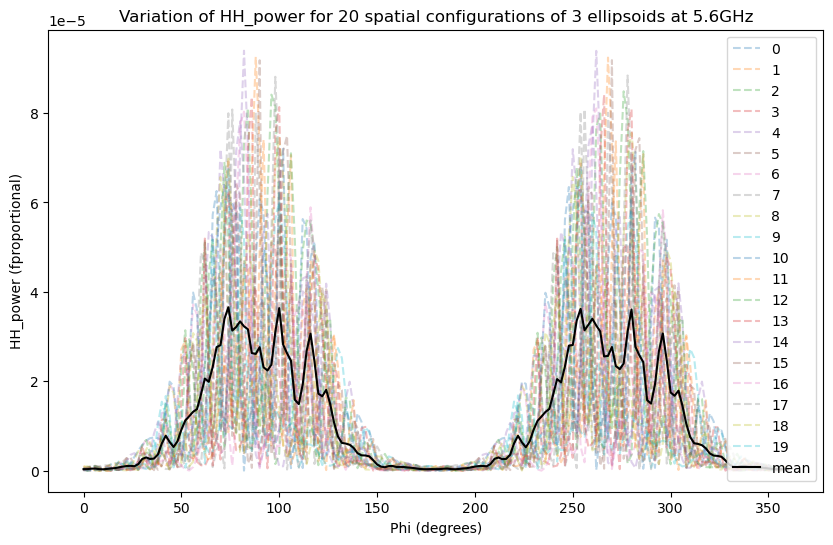

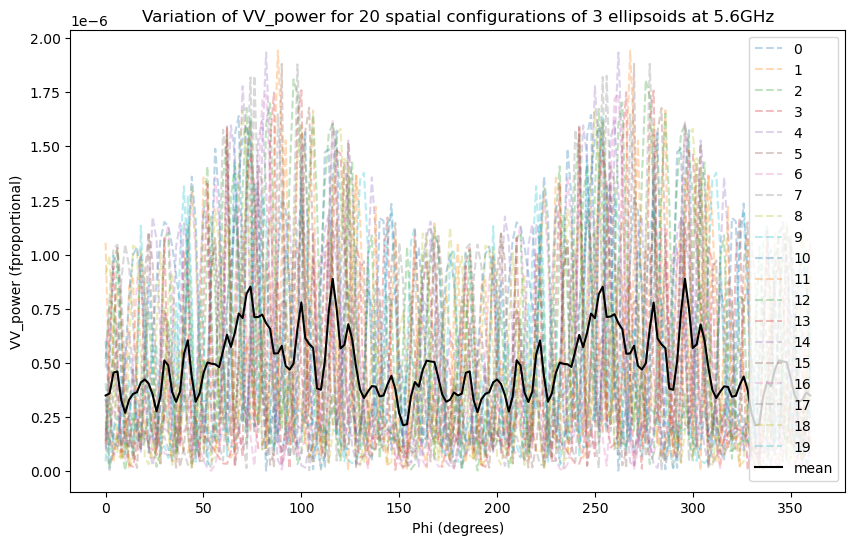

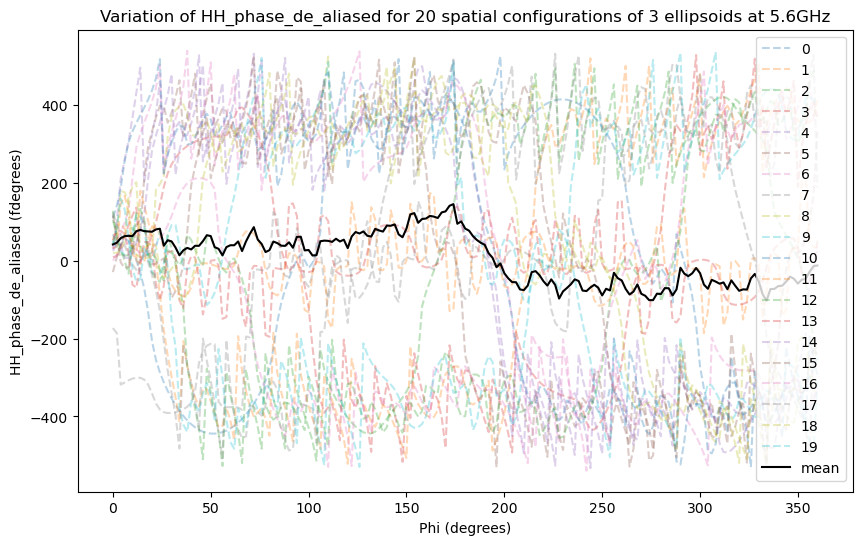

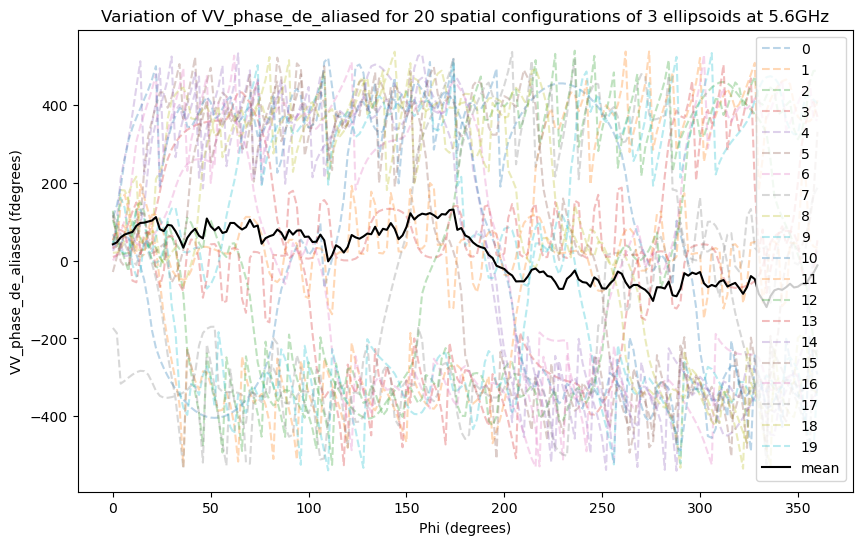

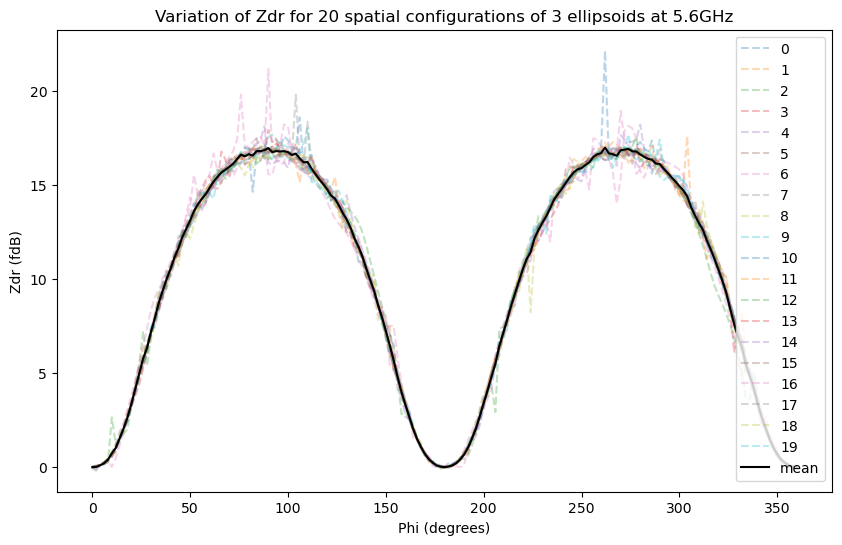

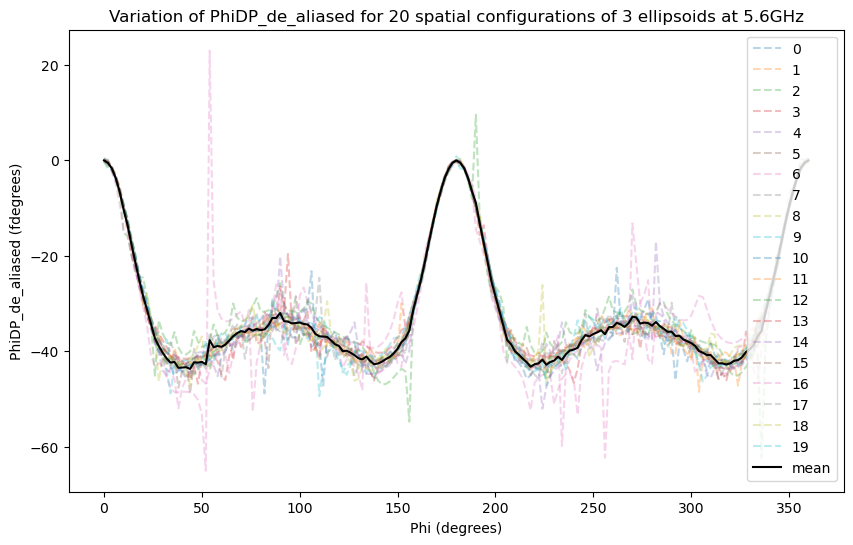

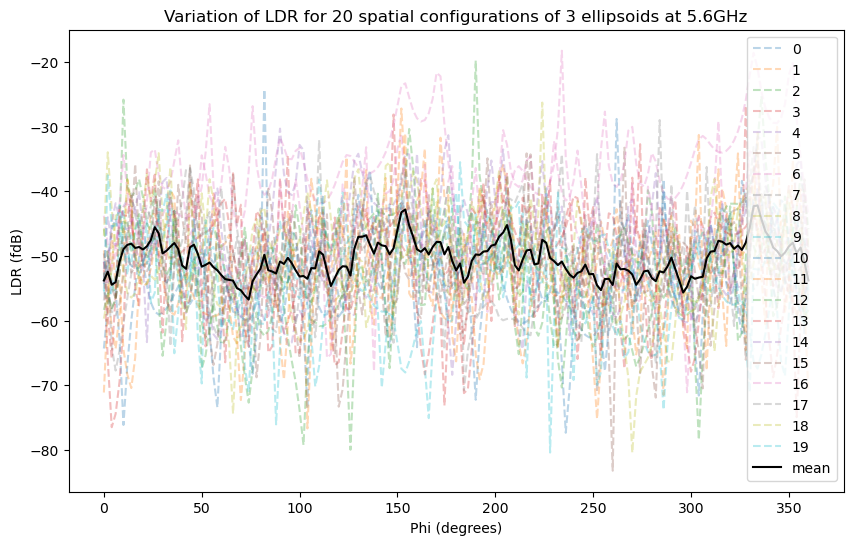

In [47]:
title_centre = '20 spatial configurations of 3 ellipsoids'

linestyle = '--'
alpha = 0.3
num_configs = 20 
results_dictionary =ellipsoid_results_dict
means_dictionary = means_dict

plot_multi_body_results(ellipsoid_results_dict, means_dict, 'HH_power', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(ellipsoid_results_dict, means_dict, 'VV_power', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(ellipsoid_results_dict, means_dict, 'HH_phase', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(ellipsoid_results_dict, means_dict, 'VV_phase', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(ellipsoid_results_dict, means_dict, 'HH_phase_de_aliased', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(ellipsoid_results_dict, means_dict, 'VV_phase_de_aliased', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(ellipsoid_results_dict, means_dict, 'Zdr', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(ellipsoid_results_dict, means_dict, 'PhiDP', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(ellipsoid_results_dict, means_dict, 'PhiDP_de_aliased', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(ellipsoid_results_dict, means_dict, 'PhiDP_pre_de_aliased', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(ellipsoid_results_dict, means_dict, 'LDR', title_centre, num_configs, linestyle, alpha)

# Unwrapping the phase

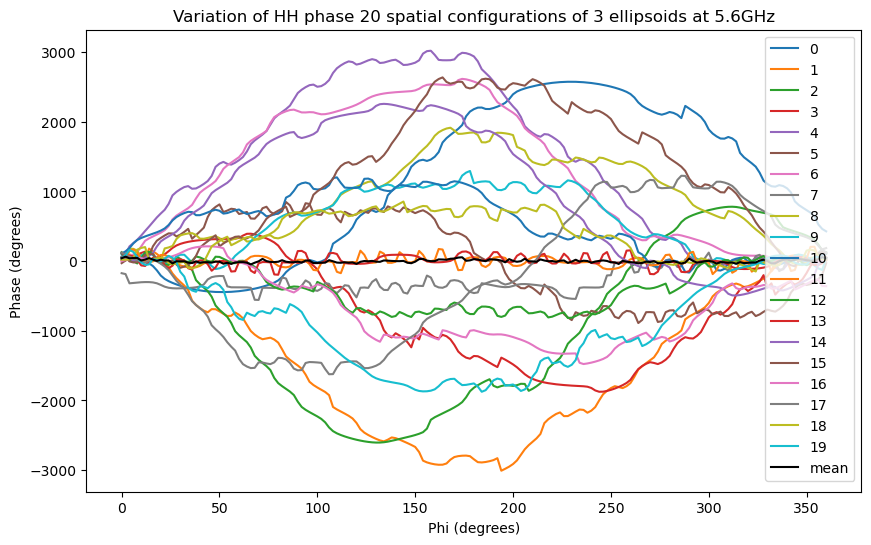

In [48]:

for coordinate_row in range(20): 

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]
    phase_rad = np.deg2rad(ellipsoid_results_dict[coordinate_row]['HH_phase'])
    unwrapped_rad = np.unwrap(phase_rad, discont = np.pi)
    unwrapped_deg = np.rad2deg(unwrapped_rad)

    plt.plot(df['phi'], unwrapped_deg, label=f'{coordinate_row}')

plt.plot(df['phi'], means_dict['HH_phase'], label='mean', linestyle = 'solid', alpha=1.0, color='black')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Phase (degrees)')
plt.title(f'Variation of HH phase {title_centre} at 5.6GHz')
plt.show()

# Bernard

In [79]:
bernard_counter = 15

In [80]:
bernard_body_data_dict = {x: {y: None for y in range(bernard_counter)} for x in pol_list}

In [81]:
for pol in pol_list:
    for coordinate_row in range(bernard_counter):
        path = BASE_DRIVE_PATH + BERNARD_BODY + f'Three_bernard_body_056_10_20_100_30_row{coordinate_row}_{pol}_dict.pkl'
        conv = converter.from_pickle(path)
        df = conv.generate_output_df()
        
        output_path = BASE_DRIVE_PATH + BERNARD_BODY + f'Three_bernard_body_056_10_20_100_30_row{coordinate_row}_{pol}_df.csv'
        df.to_csv(output_path)
        bernard_body_data_dict[pol][coordinate_row] = df    


In [82]:
bernard_body_results_dict = {y : {z : None for z in vars_list} for y in range(bernard_counter)}


for coordinate_row in range(bernard_counter): 
    bernard_body_results_dict[coordinate_row]['HH_power'] = hf.get_horizontal_returned_power(bernard_body_data_dict['H'][coordinate_row])
    bernard_body_results_dict[coordinate_row]['VV_power'] = hf.get_vertical_returned_power(bernard_body_data_dict['V'][coordinate_row])
    bernard_body_results_dict[coordinate_row]['HH_phase'] = hf.get_horizontal_returned_phase(bernard_body_data_dict['H'][coordinate_row])
    bernard_body_results_dict[coordinate_row]['VV_phase'] = hf.get_vertical_returned_phase(bernard_body_data_dict['V'][coordinate_row])
    bernard_body_results_dict[coordinate_row]['HH_phase_de_aliased'] = de_alias(bernard_body_results_dict[coordinate_row]['HH_phase'])
    bernard_body_results_dict[coordinate_row]['VV_phase_de_aliased'] = de_alias(bernard_body_results_dict[coordinate_row]['VV_phase'])
    bernard_body_results_dict[coordinate_row]['LDR'] = hf.get_linear_depol_ratio(bernard_body_data_dict['H'][coordinate_row])

    dp = DualPol(bernard_body_data_dict['H'][coordinate_row], bernard_body_data_dict['V'][coordinate_row], read_from_df=True)
    dp._calculate_differential_reflectivity()
    dp._calculate_differential_phase()

    bernard_body_results_dict[coordinate_row]['Zdr'] = dp.differential_reflectivity
    bernard_body_results_dict[coordinate_row]['PhiDP'] = dp.differential_phase
    bernard_body_results_dict[coordinate_row]['PhiDP_de_aliased'] = de_alias(bernard_body_results_dict[coordinate_row]['PhiDP'])

    if np.mean(bernard_body_results_dict[coordinate_row]['PhiDP_de_aliased']) > 180:
        bernard_body_results_dict[coordinate_row]['PhiDP_de_aliased'] = bernard_body_results_dict[coordinate_row]['PhiDP_de_aliased'] - 360

In [83]:
bernard_body_means_dict = {x: None for x in vars_list}
for var in vars_list:
    results = np.zeros((bernard_counter, 181))
    for coordinate_row in range(bernard_counter):
        results[coordinate_row] = bernard_body_results_dict[coordinate_row][var]
    bernard_body_means_dict[var] = np.mean(results, axis=0)


## Bernard plots

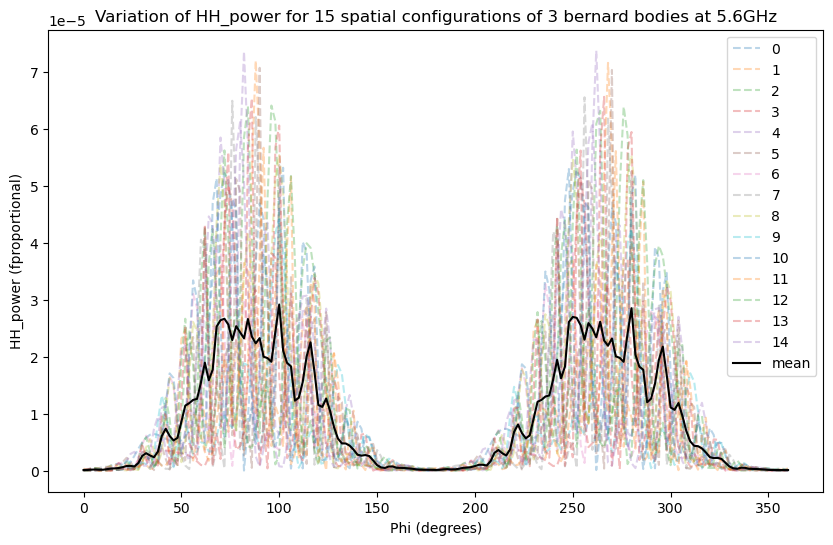

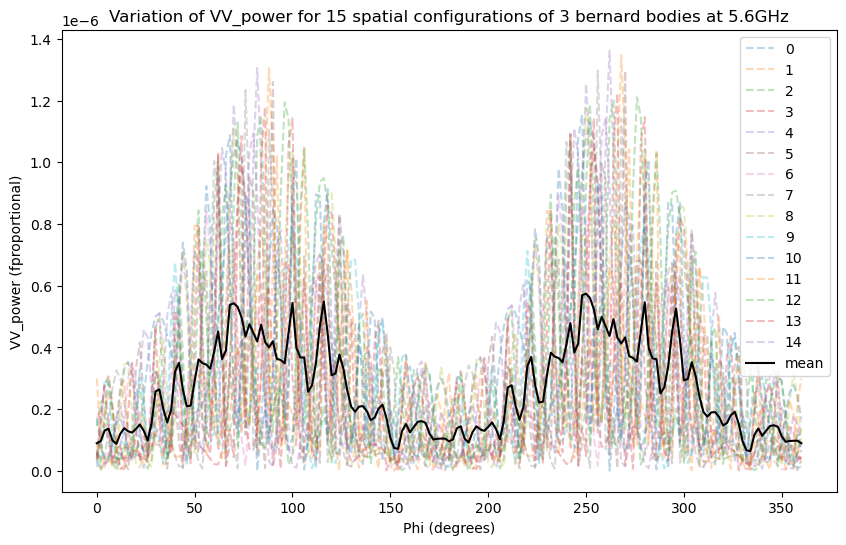

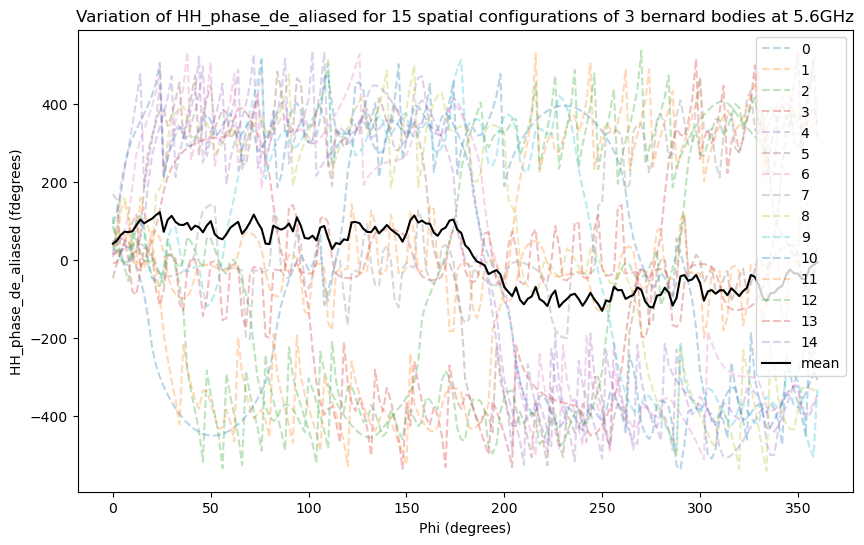

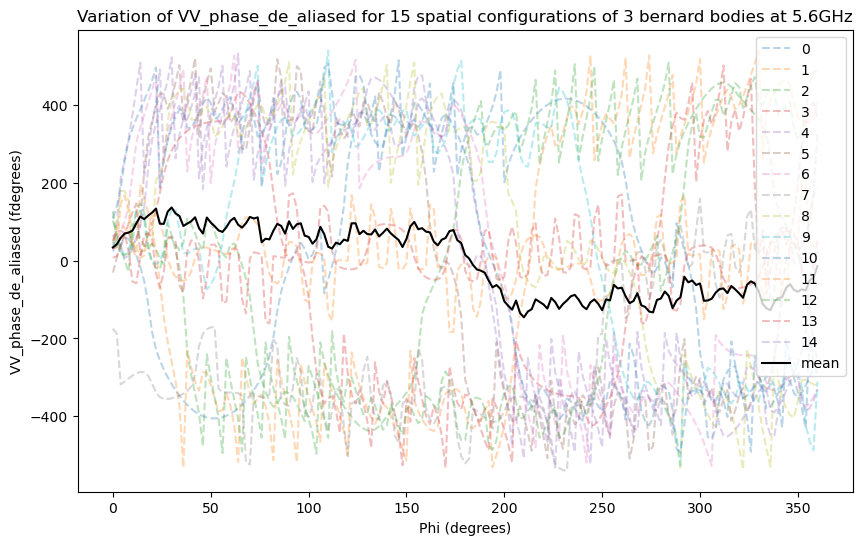

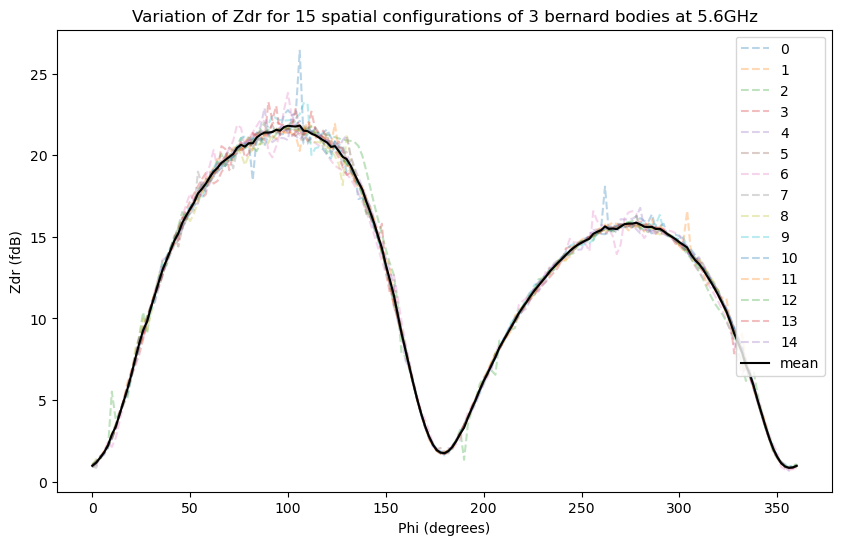

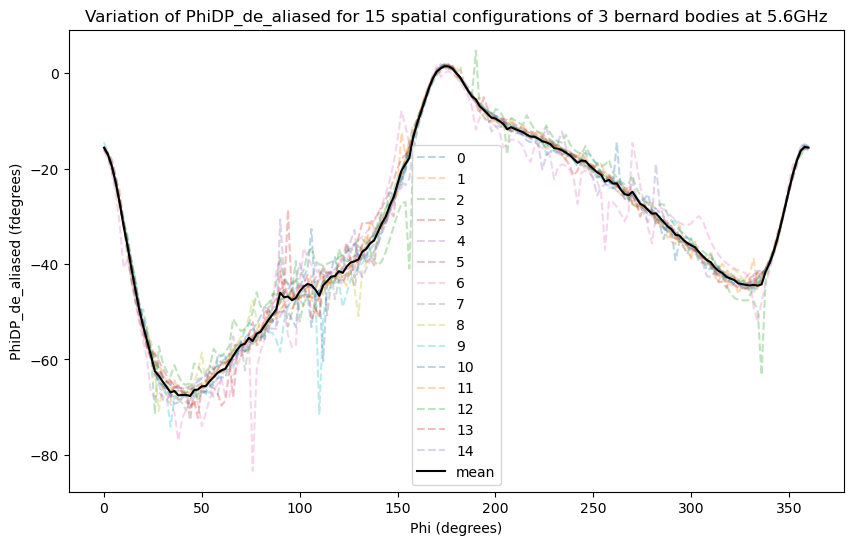

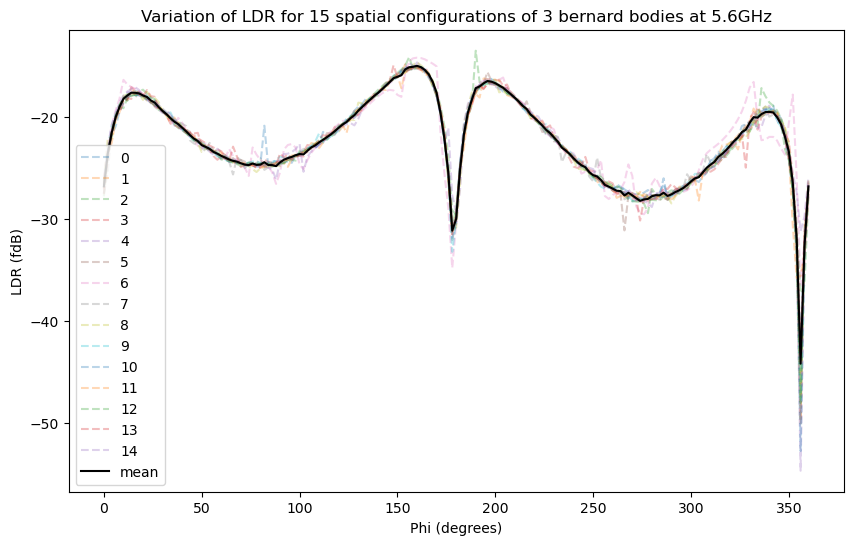

In [84]:
title_centre = f'{bernard_counter} spatial configurations of 3 bernard bodies'

linestyle = '--'
alpha = 0.3
num_configs = bernard_counter
results_dictionary =bernard_body_results_dict
means_dictionary = bernard_body_means_dict

plot_multi_body_results(results_dictionary, means_dictionary, 'HH_power', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(results_dictionary, means_dictionary, 'VV_power', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(results_dictionary, means_dictionary, 'HH_phase', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(results_dictionary, means_dictionary, 'VV_phase', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(results_dictionary, means_dictionary, 'HH_phase_de_aliased', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(results_dictionary, means_dictionary, 'VV_phase_de_aliased', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(results_dictionary, means_dictionary, 'Zdr', title_centre, num_configs, linestyle, alpha)
#plot_multi_body_results(results_dictionary, means_dictionary, 'PhiDP', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(results_dictionary, means_dictionary, 'PhiDP_de_aliased', title_centre, num_configs, linestyle, alpha)
plot_multi_body_results(results_dictionary, means_dictionary, 'LDR', title_centre, num_configs, linestyle, alpha)

# Comparison

Text(0.5, 1.0, 'Variation of HH phase 5 spatial configurations of 3 bernard bodies at 5.6GHz')

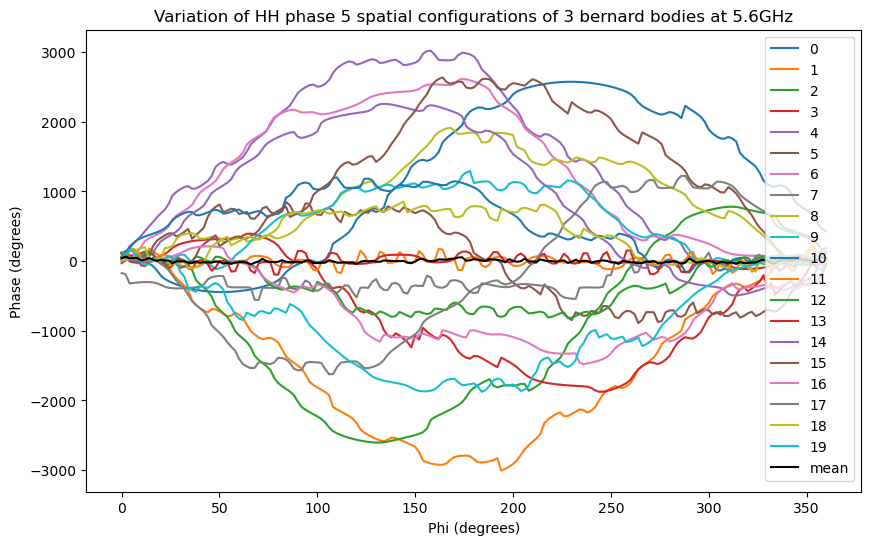

In [55]:

for coordinate_row in range(20): 

   #df_ellipsoid = ellipsoid_results_dict[pol][scale]
    phase_rad = np.deg2rad(ellipsoid_results_dict[coordinate_row]['HH_phase'])
    unwrapped_rad = np.unwrap(phase_rad, discont = np.pi)
    unwrapped_deg = np.rad2deg(unwrapped_rad)

    plt.plot(df['phi'], unwrapped_deg, label=f'{coordinate_row}')

plt.plot(df['phi'], means_dict['HH_phase'], label='mean', linestyle = 'solid', alpha=1.0, color='black')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.xlabel('Phi (degrees)')
plt.ylabel('Phase (degrees)')
plt.title(f'Variation of HH phase {title_centre} at 5.6GHz')

# Comparison to single body
## This shows the difference to the second order scattering (for the differential products)

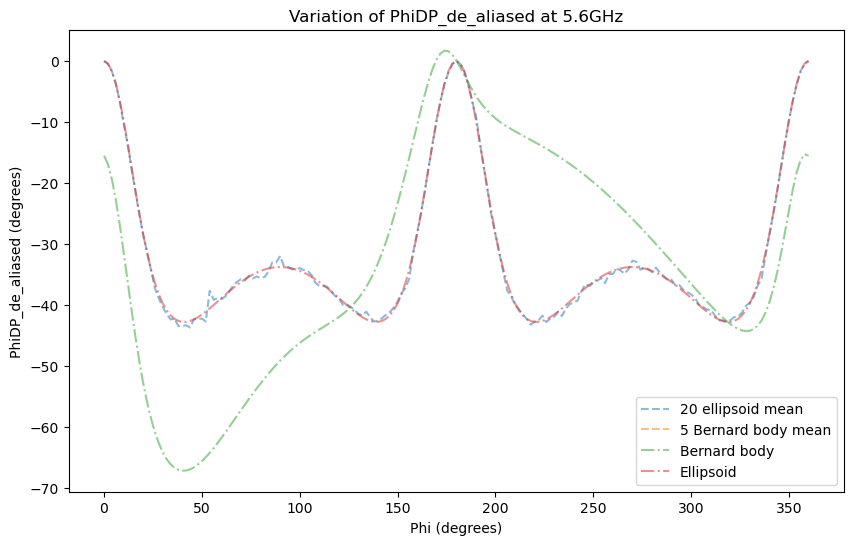

In [56]:
var='PhiDP_de_aliased'
var_compare = 'PhiDP'
linstyle = ':'
alpha = 0.5

plt.plot(df['phi'], means_dict[var], label='20 ellipsoid mean', linestyle = linestyle, alpha=alpha)
plt.plot(df['phi'], bernard_body_means_dict[var], label=f'5 Bernard body mean', linestyle = linestyle, alpha=alpha)
plt.plot(df['phi'], comparison_results_dict['Bernard_body'][var_compare], label='Bernard body', linestyle = '-.', alpha=alpha)
plt.plot(df['phi'], comparison_results_dict['Ellipsoid'][var_compare], label='Ellipsoid', linestyle = '-.', alpha=alpha)


fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
#plt.ylim(-80, 40)
plt.xlabel('Phi (degrees)')
plt.ylabel(f'{var} ({units_dict[var]})')
plt.title(f'Variation of {var} at 5.6GHz')
plt.show()

Text(0.5, 1.0, 'Variation of Zdr at 5.6GHz')

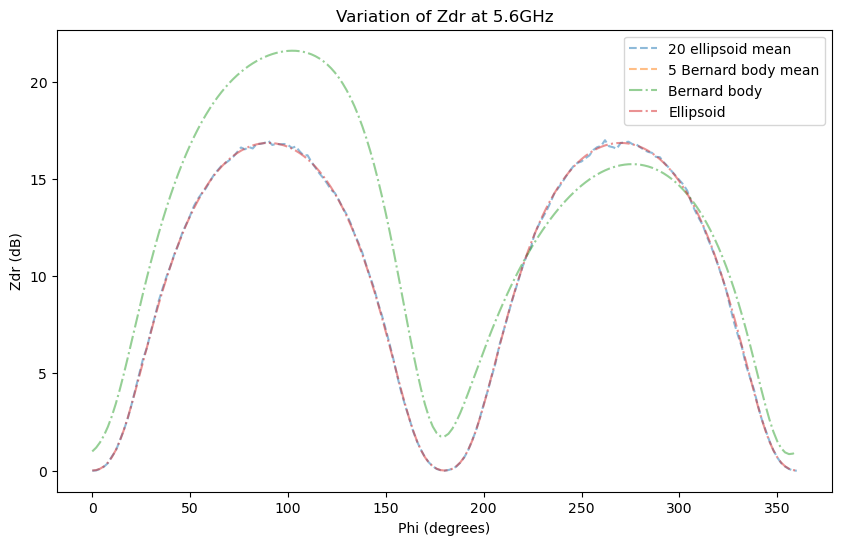

In [57]:
var='Zdr'
linstyle = ':'
alpha = 0.5

plt.plot(df['phi'], means_dict[var], label='20 ellipsoid mean', linestyle = linestyle, alpha=alpha)
plt.plot(df['phi'], bernard_body_means_dict[var], label=f'5 Bernard body mean', linestyle = linestyle, alpha=alpha)
plt.plot(df['phi'], comparison_results_dict['Bernard_body'][var], label='Bernard body', linestyle = '-.', alpha=alpha)
plt.plot(df['phi'], comparison_results_dict['Ellipsoid'][var], label='Ellipsoid', linestyle = '-.', alpha=alpha)


fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
#plt.ylim(-80, 40)
plt.xlabel('Phi (degrees)')
plt.ylabel(f'{var} ({units_dict[var]})')
plt.title(f'Variation of {var} at 5.6GHz')

# Calculating rho_hv

In [58]:
def calculate_rho_hv(data_dict, n_samples):
    horizontal_phi = np.zeros((n_samples, 181))
    vertical_theta = np.zeros((n_samples, 181))

    rho_hv = np.zeros((n_samples, 181))

    for coordinate_row in range(n_samples):
        horizontal_phi[coordinate_row] = data_dict['H'][coordinate_row]['Ephi']
        vertical_theta[coordinate_row] = data_dict['V'][coordinate_row]['Etheta']

    coordinate_level_correlation = np.conj(horizontal_phi) * vertical_theta
    coordinate_level_hh_power = np.abs(horizontal_phi) ** 2
    coordinate_level_vv_power = np.abs(vertical_theta) ** 2

    mean_correlation = np.mean(coordinate_level_correlation, axis=0)
    mean_hh_power = np.mean(coordinate_level_hh_power, axis=0)
    mean_vv_power = np.mean(coordinate_level_vv_power, axis=0)
    rho_hv = np.abs(mean_correlation) / np.sqrt(mean_hh_power * mean_vv_power)
    return rho_hv




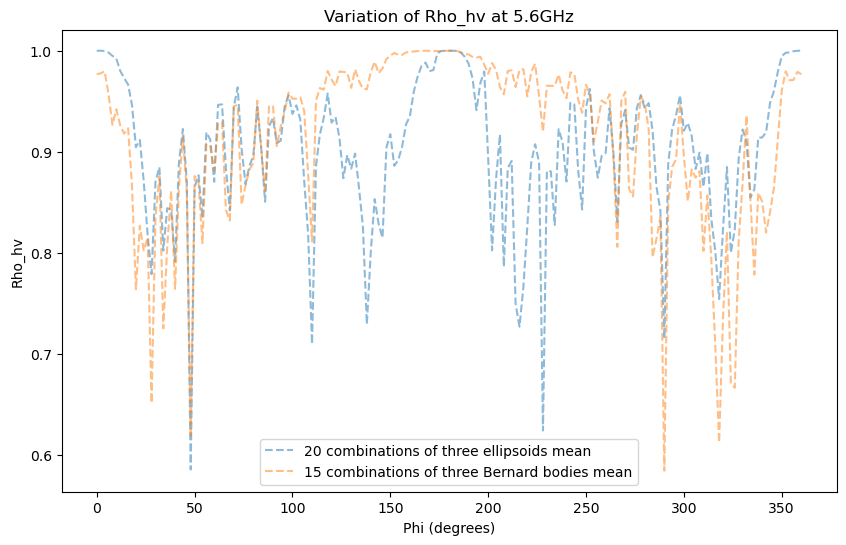

In [62]:
plt.plot(df['phi'], calculate_rho_hv(data_dict, 20), label='20 combinations of three ellipsoids mean', linestyle = linestyle, alpha=alpha)
plt.plot(df['phi'], calculate_rho_hv(bernard_body_data_dict, bernard_counter), label=f'{bernard_counter} combinations of three Bernard bodies mean', linestyle = linestyle, alpha=alpha)

plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.xlabel('Phi (degrees)')
plt.ylabel(f'Rho_hv')
plt.title(f'Variation of Rho_hv at 5.6GHz')
plt.show()

### More de-correlation at side on